# Анализ данных магазина Стримчик (1 сборный проект)

В современном мире компьютерные игры представляют собой динамичную и конкурентоспособную индустрию, в которой успешность продукта зависит от разнообразных факторов. На основе предоставленных данных о компьютерных играх до 2016 года, наша задача заключается в выявлении закономерностей, определяющих успешность игр. Это позволит сделать ставку на потенциально популярные продукты и разработать эффективные рекламные кампании. Кроме того, мы ставим перед собой цель подготовить данные для предсказания развития рынка в будущем.

В анализе данных мы обращаем внимание на различные параметры, такие как название игры, платформа, год выпуска, жанр, продажи в различных регионах, оценки критиков и пользователей, а также рейтинг от ESRB, который определяет возрастную категорию для каждой игры.

Эти данные позволят нам выделить ключевые факторы, влияющие на успешность игр, и сформулировать рекомендации для разработчиков и маркетологов. Анализ ESRB рейтинга также предоставит дополнительный контекст, связанный с возрастными ограничениями, что может быть важным аспектом в планировании маркетинговых стратегий.

Описание предоставленных данных:
Name — название игры
Platform — платформа
Year_of_Release — год выпуска
Genre — жанр игры
NA_sales — продажи в Северной Америке (миллионы проданных копий)
EU_sales — продажи в Европе (миллионы проданных копий)
JP_sales — продажи в Японии (миллионы проданных копий)
Other_sales — продажи в других странах (миллионы проданных копий)
Critic_Score — оценка критиков (максимум 100)
User_Score — оценка пользователей (максимум 10)
Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board).Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

# Загрузка данных

In [1]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [2]:
from scipy.stats import binom
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import pandas as pd
from scipy import stats as st
import seaborn as sns

In [3]:
df = pd.read_csv('/datasets/games.csv')

In [4]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Расмотрев полученые данные видно, что у некоторых столбцов не верный тип данных.Нужно изменить на верный.Всего 16715 записей,но их надо прорверить на дубликаты. 

# Предобработка данных

### Замена названия столбцов

In [6]:
new_name = []

for i in df.columns:
    i = i.lower()
    new_name.append(i)

df.columns = new_name

Изменил регистр названия столбцов 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [8]:
df.user_score.value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
2.3       2
1.3       2
0.5       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

Я подумал, что столбец users_score необходимо преоброзовать в тип float тк в нем в большинстве числовые данные,но позже я выяснил что в этом столбце так же присутствует запись tbd(предстоит оценить).Таких записей 2424 поэтому удалить их нельзя из за этого нельзя переобразовать тип данных этого столбца.

### Обработка пропусков

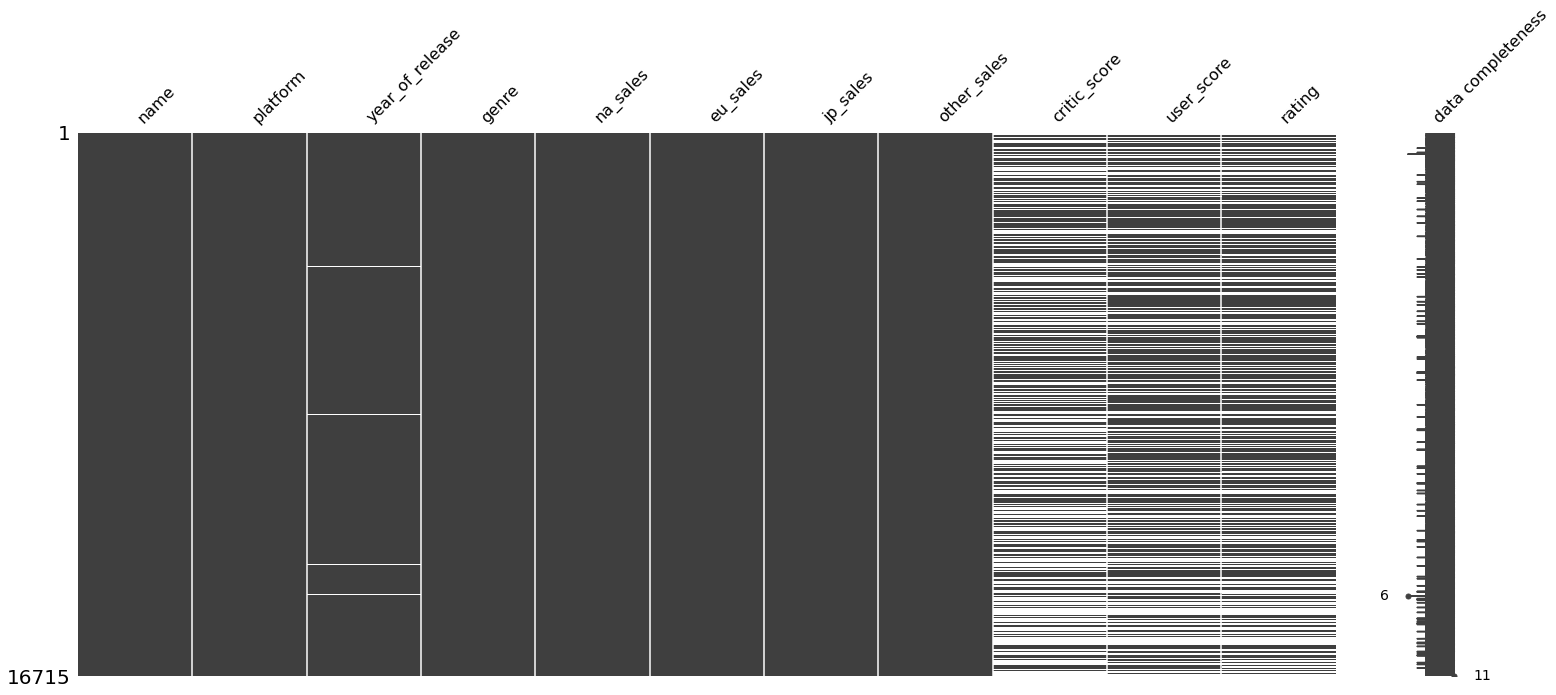

In [9]:
msno.matrix(df, labels=True)#много пропусков в столбцах user_score,critic_score и rating
plt.show()

Очень много пропусков в столбцах с рейтингом.Некоторые из этих игр еще не были оценены, но здесь явно, что то произошло с данными. Люди могли случайно не зполнить некоторые поля, но тк пропусков очен много скорее всего файл с данными исказился при отправке.

In [10]:
print(df.isna().sum()) # в столбце rating 8578 пропусков(почти половна всех записей)
print(df.shape) # всего 16715 записей

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64
(16715, 11)


In [11]:
print(df.user_score.unique())
df.user_score = df.user_score.replace('tbd', np.nan)
print()
print(df.user_score.unique())

['8' nan '8.3' '8.5' '6.6' '8.4' '8.6' '7.7' '6.3' '7.4' '8.2' '9' '7.9'
 '8.1' '8.7' '7.1' '3.4' '5.3' '4.8' '3.2' '8.9' '6.4' '7.8' '7.5' '2.6'
 '7.2' '9.2' '7' '7.3' '4.3' '7.6' '5.7' '5' '9.1' '6.5' 'tbd' '8.8' '6.9'
 '9.4' '6.8' '6.1' '6.7' '5.4' '4' '4.9' '4.5' '9.3' '6.2' '4.2' '6' '3.7'
 '4.1' '5.8' '5.6' '5.5' '4.4' '4.6' '5.9' '3.9' '3.1' '2.9' '5.2' '3.3'
 '4.7' '5.1' '3.5' '2.5' '1.9' '3' '2.7' '2.2' '2' '9.5' '2.1' '3.6' '2.8'
 '1.8' '3.8' '0' '1.6' '9.6' '2.4' '1.7' '1.1' '0.3' '1.5' '0.7' '1.2'
 '2.3' '0.5' '1.3' '0.2' '0.6' '1.4' '0.9' '1' '9.7']

['8' nan '8.3' '8.5' '6.6' '8.4' '8.6' '7.7' '6.3' '7.4' '8.2' '9' '7.9'
 '8.1' '8.7' '7.1' '3.4' '5.3' '4.8' '3.2' '8.9' '6.4' '7.8' '7.5' '2.6'
 '7.2' '9.2' '7' '7.3' '4.3' '7.6' '5.7' '5' '9.1' '6.5' '8.8' '6.9' '9.4'
 '6.8' '6.1' '6.7' '5.4' '4' '4.9' '4.5' '9.3' '6.2' '4.2' '6' '3.7' '4.1'
 '5.8' '5.6' '5.5' '4.4' '4.6' '5.9' '3.9' '3.1' '2.9' '5.2' '3.3' '4.7'
 '5.1' '3.5' '2.5' '1.9' '3' '2.7' '2.2' '2' '9.5' '2.1' '3.6

В df встречаются такие данные как 'tbd'. Это сокращение расшифровывается, как:to be decided, что в переводе означает:'будет решено'. Заменил это значение на пропуск, что бы оно не мешало дальнейшему анализу.

### Изменение типов данных

In [12]:
df = df.dropna(subset=['year_of_release'])

Удалил пропуски в столбцес годами, тк их не много и эти данные важны для дальнейшего анализа


In [13]:
df.year_of_release = df.year_of_release.astype('int')

Год это целочисленное значение поэтому больше подойдет тип данных int.

In [14]:
df.user_score = df.user_score.astype('float')

Изменил тип данных, тк теперь в этом столбце нет значения tbd, а это значит, что нет смысла оставлять эти данные типом object.


### Удаление дубликатов

In [15]:
print(df.duplicated(subset=['name', 'platform', 'year_of_release']).sum()) #дубликаты не найдны

df = df.drop_duplicates(subset=['name', 'platform', 'year_of_release'])

if df.duplicated().sum() == 0:
    print("Дубликаты успешно удалены.")
else:
    print("Произошла ошибка при удалении дубликатов.")

2
Дубликаты успешно удалены.


### Добавление нового столбца

In [16]:
df['sales_total'] = df.na_sales + df.eu_sales + df.jp_sales + df.other_sales

Создал столбцец с сумарными продажами по регионам.


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16443 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       7462 non-null   float64
 10  rating           9767 non-null   object 
 11  sales_total      16444 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB


<b>Вывод по предобработке данных</b> 
<div>Я изменил тип данных для года выпуска игр, удалил дубликаты и пропуски в годах релиза, добавил столбец с сумарными продажами по всем регионам.


# Иследовательский анализ

In [18]:
def plotbar(df, ind, val, func, name, x, y):  # написал функцию чтобы не повторялся код
    data = df.pivot_table(index=ind, values=val, aggfunc=func)
    data.plot.bar()
    plt.title(name)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.figure(figsize=(12, 8))
    plt.show()

def plotbar_filtered(df, ind, val, func, name, x, y):  # написал функцию чтобы не повторялся код
    data = df.pivot_table(index=ind, values=val, aggfunc=func).sort_values(by = val,ascending = False)
    data.plot.bar()
    plt.title(name)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.figure(figsize=(10, 6))
    plt.show()

### Выпуск игр по годам

In [19]:
years = pd.pivot_table(df, index='year_of_release', values='name',
                       aggfunc='count')  # сводная таблица по количеству игр выпущенных в разные года
years

,name
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


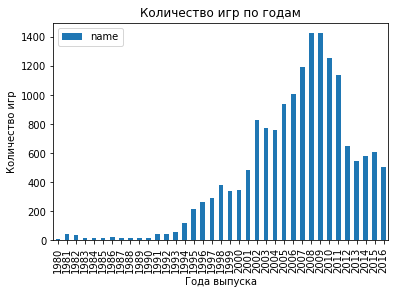

<Figure size 864x576 with 0 Axes>

In [20]:
plotbar(df, 'year_of_release', 'name', 'count', 'Количество игр по годам', 'Года выпуска', 'Количество игр')

С 2001 начался сильный рост количества выпущеных игр.Больше всего игр было выпущено в период с 2008 по 2009.После 2009 количество выпускаемых игр пошло на спад.

### Изменения по платформам

In [21]:
platforms_per_year = pd.pivot_table(df, index=['platform', 'year_of_release'], values='sales_total',
                                    aggfunc='sum')  # продажи всех платформ по годам
platforms_per_year

sales_total
platform year_of_release             
2600     1980                   11.38
         1981                   35.68
         1982                   28.88
         1983                    5.84
         1984                    0.27
...                               ...
XB       2008                    0.18
XOne     2013                   18.96
         2014                   54.07
         2015                   60.14
         2016                   26.15

[238 rows x 1 columns]

In [22]:
platforms_top = pd.pivot_table(df, index='platform', values='sales_total', aggfunc='sum').sort_values(by='sales_total',
                                                                                                      ascending=False)
platforms_top.head(5)

,sales_total
platform,
PS2,1233.56
X360,961.24
PS3,931.33
Wii,891.18
DS,802.78


Больше всего продаж у PS2,X360,Wii,PS3,DS


In [23]:
def platform_year_stat(platform, name, x, y):  # написал функцию чтобы не повторялся код
    data = df[df['platform'] == platform].pivot_table(index='year_of_release', values='sales_total', aggfunc='sum')
    data.plot.bar()
    plt.title(name)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

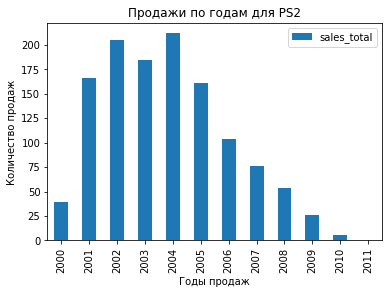

In [24]:
platform_year_stat('PS2', 'Продажи по годам для PS2', 'Годы продаж', 'Количество продаж')

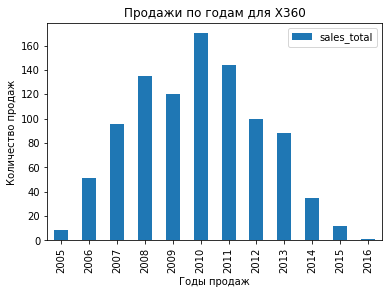

In [25]:
platform_year_stat('X360', 'Продажи по годам для X360', 'Годы продаж', 'Количество продаж')

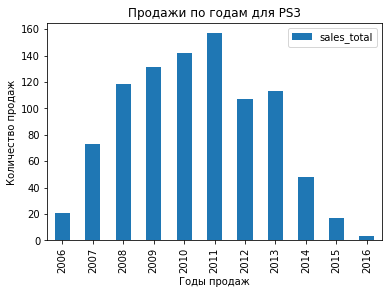

In [26]:
platform_year_stat('PS3', 'Продажи по годам для PS3', 'Годы продаж', 'Количество продаж')

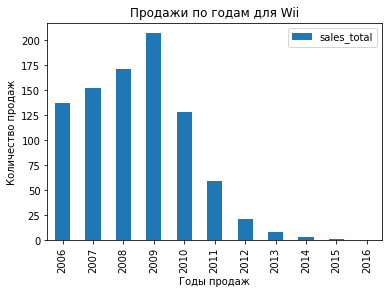

In [27]:
platform_year_stat('Wii', 'Продажи по годам для Wii', 'Годы продаж', 'Количество продаж')

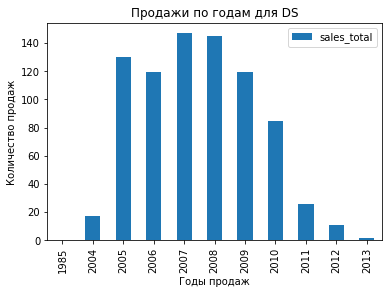

In [28]:
platform_year_stat('DS', 'Продажи по годам для DS', 'Годы продаж', 'Количество продаж')

Построил графики с рапределением продаж для самых популярных платформ


In [29]:
platform_first_year = df.groupby('platform')['year_of_release'].min().reset_index()
platform_last_year = df.groupby('platform')['year_of_release'].max().reset_index()
platform_first_year.columns = ['platform', 'first_year']
platform_last_year.columns = ['platform', 'last_year']
platform_years = pd.merge(platform_first_year, platform_last_year, on='platform')
platform_years#составил таблицу с данными о первом и последнем годах платформ

,platform,first_year,last_year
0,2600,1980,1989
1,3DO,1994,1995
2,3DS,2011,2016
3,DC,1998,2008
4,DS,1985,2013
5,GB,1988,2001
6,GBA,2000,2007
7,GC,2001,2007
8,GEN,1990,1994
9,GG,1992,1992


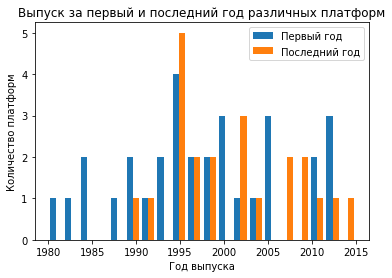

In [30]:
x = platform_years.loc[platform_years['last_year'] == 2016, 'last_year'] = np.nan#данные заканчиваются на 2016 а это значит, что платформа могла не закрыться
plt.hist([platform_years['first_year'], platform_years['last_year']], bins=20, label=['Первый год', 'Последний год'])
plt.title('Выпуск за первый и последний год различных платформ')
plt.xlabel('Год выпуска')
plt.ylabel('Количество платформ')
plt.legend()
plt.show()

графики показали что больше всего платформ появилось в период с 1990 по 2005 год, а больше всего ушло в период с 1995 по 2010


### Предсказание для рынка платформ

In [31]:
#изучив данные я понял, что в среднем плаформы имеют выские продажи около 5-7 лет.Это и определяет актуальный период, но я округлил до 10 отталкиваясь от анных графика.
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    platforms_per_year = platforms_per_year.reset_index()
    print(platforms_per_year.query("year_of_release >= 2010").to_string())

    platform  year_of_release  sales_total
12       3DS             2011        63.20
13       3DS             2012        51.36
14       3DS             2013        56.57
15       3DS             2014        43.76
16       3DS             2015        27.78
17       3DS             2016        15.14
32        DS             2010        85.02
33        DS             2011        26.18
34        DS             2012        11.01
35        DS             2013         1.54
112       PC             2010        24.28
113       PC             2011        35.03
114       PC             2012        23.22
115       PC             2013        12.38
116       PC             2014        13.28
117       PC             2015         8.52
118       PC             2016         5.25
140      PS2             2010         5.64
141      PS2             2011         0.45
146      PS3             2010       142.17
147      PS3             2011       156.78
148      PS3             2012       107.35
149      PS

In [32]:
def analyze_platform_trend(data, years_to_check=3):
    result_df = pd.DataFrame(columns=['Platform', 'Status'])
    grouped_data = data.groupby('platform')
    
    for platform, platform_data in grouped_data:
        if len(platform_data) < years_to_check or platform_data.year_of_release.max() != 2016:
            status = 'Платформа закрылась'
        else:
            sales_change = platform_data.sales_total.pct_change().head(years_to_check).mean()
            status = 'Продажи растут. Платформа выгодна для вложения' if sales_change > 0 else 'Продажи падают. Платформа может скоро закрыться'
        result_df = result_df.append({'Platform': platform, 'Status': status}, ignore_index=True)
    
    return result_df

In [33]:
actual_data = df.query("year_of_release >= 2013")
actual_data_platforms = platforms_per_year.query("year_of_release >= 2013")
analyze_platform_trend(actual_data_platforms)

,Platform,Status
0,3DS,Продажи падают. Платформа может скоро закрыться
1,DS,Платформа закрылась
2,PC,Продажи падают. Платформа может скоро закрыться
3,PS3,Продажи падают. Платформа может скоро закрыться
4,PS4,Продажи растут. Платформа выгодна для вложения
5,PSP,Платформа закрылась
6,PSV,Продажи падают. Платформа может скоро закрыться
7,Wii,Продажи падают. Платформа может скоро закрыться
8,WiiU,Продажи падают. Платформа может скоро закрыться
9,X360,Продажи падают. Платформа может скоро закрыться


Написал свою функцию для выбора актуальной для вложения платформы на актуальный период. Возможно эта функция могла бы лечь в основу обучения модели для предсказания для вложений.


In [34]:
platforms_top_actual = pd.pivot_table(actual_data, index='platform', values='sales_total', aggfunc='sum').sort_values(by='sales_total',
                                                                                                      ascending=False)
platforms_top_actual.head(5)

,sales_total
platform,
PS4,314.14
PS3,181.43
XOne,159.32
3DS,143.25
X360,136.80


Уже ранее написанная функция для нахождения самых больших по продажам платформ и функция описывающая рост или падения продаж показали, что самое крупные платформы либо закрылись, либо их продажи падают.


### Распределние продаж по платформам

In [35]:
actual_data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_total
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62


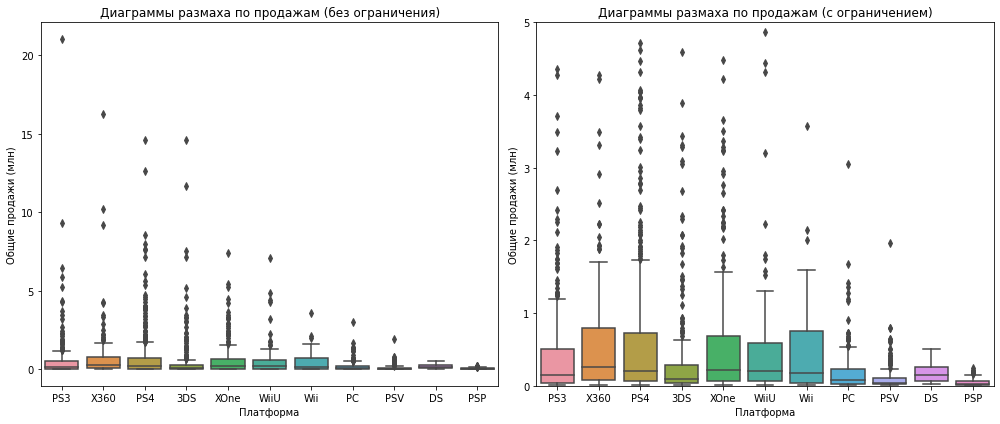

In [36]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='platform', y='sales_total', data=actual_data)
plt.title("Диаграммы размаха по продажам (без ограничения)")
plt.xlabel("Платформа")
plt.ylabel("Общие продажи (млн)")

plt.subplot(1, 2, 2)
sns.boxplot(x='platform', y='sales_total', data=actual_data)
plt.ylim(0, 5)
plt.title("Диаграммы размаха по продажам (с ограничением)")
plt.xlabel("Платформа")
plt.ylabel("Общие продажи (млн)")

plt.tight_layout()

plt.show()

Построил графики размаха,для визуализации разброса значений по платформам.


In [37]:
class Platforms_analyse():
    @staticmethod
    def plat_data(platform):
        return actual_data.query("platform == @platform")

    @staticmethod
    def scatter_user(plat_df):
        plt.figure(figsize=(14, 10))
        data = plat_df.copy()
        data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')
        plt.scatter(data['user_score'], data['sales_total'], label='Отзывы пользователей',
                color='blue')
        plt.title('Диаграмма рассеяния зависимости продаж от отзывов пользователей')
        plt.xlabel('Отзывы')
        plt.ylabel('Продажи')

        plt.show()


    @staticmethod
    def scatter_critic(plat_df):
        plt.figure(figsize=(14, 10))
        data = plat_df.copy()

        data['critic_score'] = pd.to_numeric(data['critic_score'], errors='coerce')

        plt.scatter(data['critic_score'], data['sales_total'], label='Отзывы критиков',
                color='red')
        plt.title('Диаграмма рассеяния зависимости продаж от отзывов критиков')
        plt.xlabel('Отзывы')
        plt.ylabel('Продажи')


        plt.show()

    @staticmethod
    def plat_corr(plat_df):
        plat_df['user_score'] = pd.to_numeric(plat_df['user_score'], errors='coerce')
        plat_df['critic_score'] = pd.to_numeric(plat_df['critic_score'], errors='coerce')
        correlation_user = plat_df['sales_total'].corr(plat_df['user_score'])
        correlation_critic = plat_df['sales_total'].corr(plat_df['critic_score'])
        print("Кореляция между продажами и оценкой пользователей:", correlation_user)
        print("Кореляция между продажами и оценкой критиков:", correlation_critic)


Для сокращения кода лучше написать класс(изначально я его не писал тк не знал, что придется проделывать эти действия для еще 3 платформ


### Данные для PS4

In [38]:
platform_analyzer = Platforms_analyse()
ps4_data = platform_analyzer.plat_data("PS4")
ps4_data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_total
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN,7.98
92,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83.0,5.7,M,7.66
...,...,...,...,...,...,...,...,...,...,...,...,...
16500,Root Letter,PS4,2016,Adventure,0.00,0.00,0.01,0.00,69.0,7.5,NaN,0.01
16503,Shin Hayarigami 2,PS4,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16526,Dungeons 2,PS4,2016,Role-Playing,0.01,0.00,0.00,0.00,61.0,7.9,T,0.01
16530,Carmageddon: Max Damage,PS4,2016,Action,0.01,0.00,0.00,0.00,51.0,5.5,M,0.01


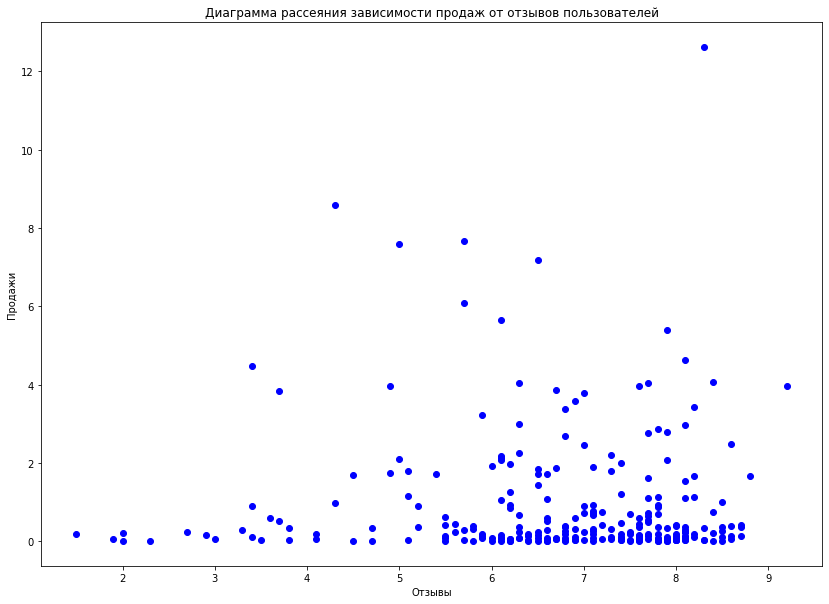

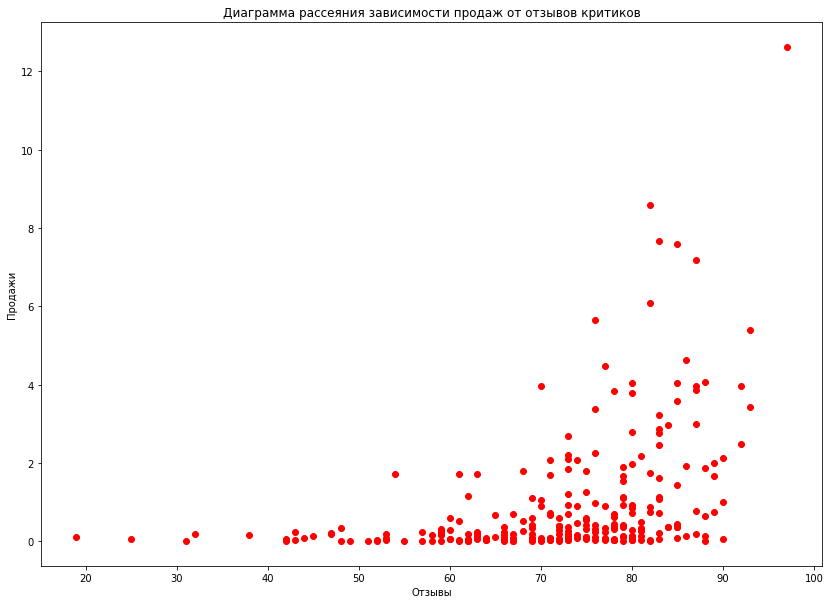

In [39]:
platform_analyzer.scatter_user(ps4_data)
platform_analyzer.scatter_critic(ps4_data)

In [40]:
platform_analyzer.plat_corr(ps4_data)

Кореляция между продажами и оценкой пользователей: -0.031957110204556376
Кореляция между продажами и оценкой критиков: 0.406567902061781


/tmp/ipykernel_164/117147021.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plat_df['user_score'] = pd.to_numeric(plat_df['user_score'], errors='coerce')
/tmp/ipykernel_164/117147021.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plat_df['critic_score'] = pd.to_numeric(plat_df['critic_score'], errors='coerce')


### Данные для PS3

In [41]:
platform_analyzer = Platforms_analyse()
ps3_data = platform_analyzer.plat_data("PS3")
ps3_data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_total
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
69,Call of Duty: Ghosts,PS3,2013,Shooter,4.10,3.63,0.38,1.25,71.0,2.6,M,9.36
126,FIFA 14,PS3,2013,Sports,0.78,4.24,0.07,1.37,86.0,4.3,E,6.46
149,The Last of Us,PS3,2013,Action,2.41,2.18,0.28,0.99,95.0,9.1,M,5.86
180,Minecraft,PS3,2014,Misc,2.03,2.37,0.00,0.87,NaN,NaN,NaN,5.27
...,...,...,...,...,...,...,...,...,...,...,...,...
16558,Naruto Shippuden: Ultimate Ninja Storm Collection,PS3,2016,Action,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
16638,Tour de France 2014,PS3,2014,Sports,0.00,0.01,0.00,0.00,NaN,NaN,E,0.01
16674,Tsukigime Ranko's Longest Day,PS3,2014,Action,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
16691,Dynasty Warriors: Eiketsuden,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01


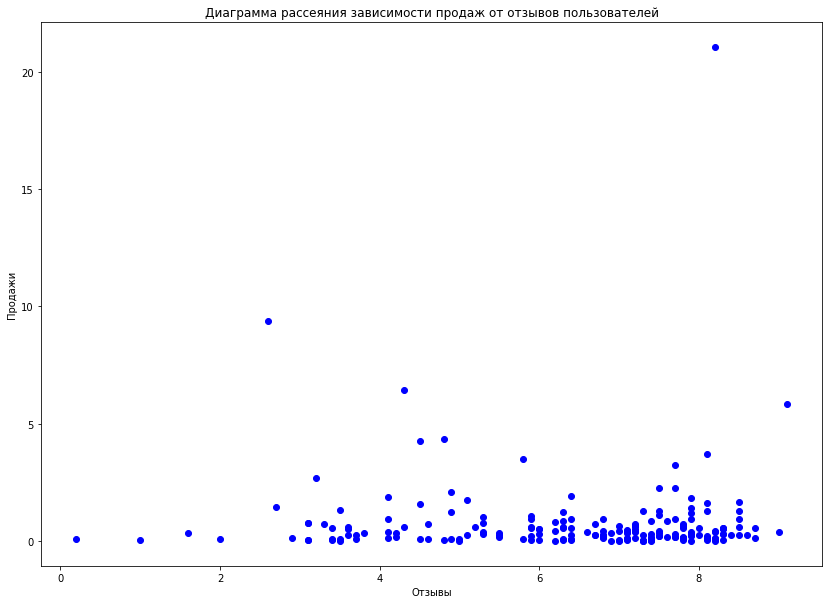

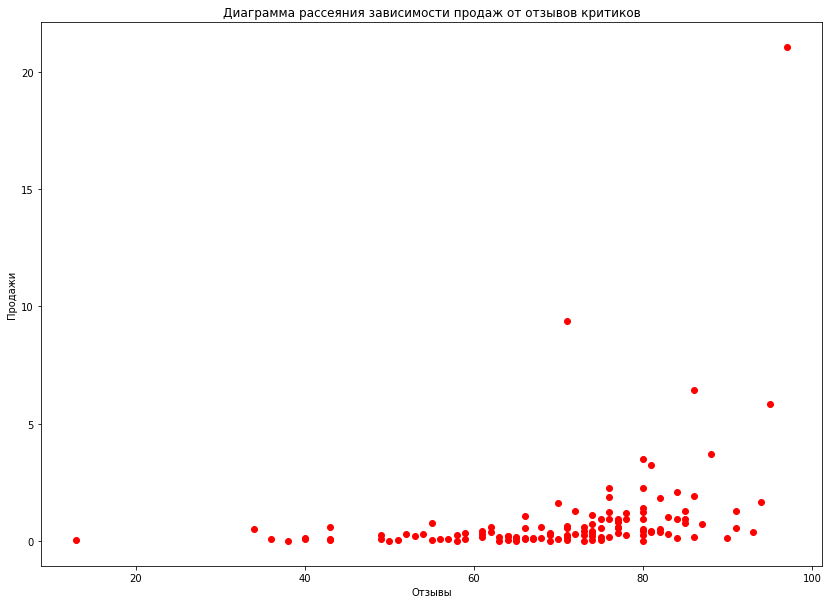

In [42]:
platform_analyzer.scatter_user(ps3_data)
platform_analyzer.scatter_critic(ps3_data)

In [43]:
platform_analyzer.plat_corr(ps3_data)

Кореляция между продажами и оценкой пользователей: 0.0023944027357566925
Кореляция между продажами и оценкой критиков: 0.3342853393371919


/tmp/ipykernel_164/117147021.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plat_df['user_score'] = pd.to_numeric(plat_df['user_score'], errors='coerce')
/tmp/ipykernel_164/117147021.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plat_df['critic_score'] = pd.to_numeric(plat_df['critic_score'], errors='coerce')


### Данные для XOne

In [44]:
platform_analyzer = Platforms_analyse()
xone_data = platform_analyzer.plat_data("XOne")
xone_data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_total
99,Call of Duty: Black Ops 3,XOne,2015,Shooter,4.59,2.11,0.01,0.68,NaN,NaN,NaN,7.39
165,Grand Theft Auto V,XOne,2014,Action,2.81,2.19,0.00,0.47,97.0,7.9,M,5.47
179,Call of Duty: Advanced Warfare,XOne,2014,Shooter,3.22,1.55,0.01,0.48,81.0,5.4,M,5.26
242,Halo 5: Guardians,XOne,2015,Shooter,2.78,1.27,0.03,0.41,84.0,6.4,T,4.49
270,Fallout 4,XOne,2015,Role-Playing,2.51,1.32,0.01,0.38,88.0,6.2,M,4.22
...,...,...,...,...,...,...,...,...,...,...,...,...
16630,Sébastien Loeb Rally Evo,XOne,2016,Racing,0.00,0.01,0.00,0.00,63.0,8.2,E,0.01
16643,Rugby Challenge 3,XOne,2016,Sports,0.00,0.01,0.00,0.00,NaN,6.6,E,0.01
16645,ZombiU,XOne,2016,Action,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
16660,Prison Architect,XOne,2016,Action,0.01,0.00,0.00,0.00,74.0,6.7,NaN,0.01


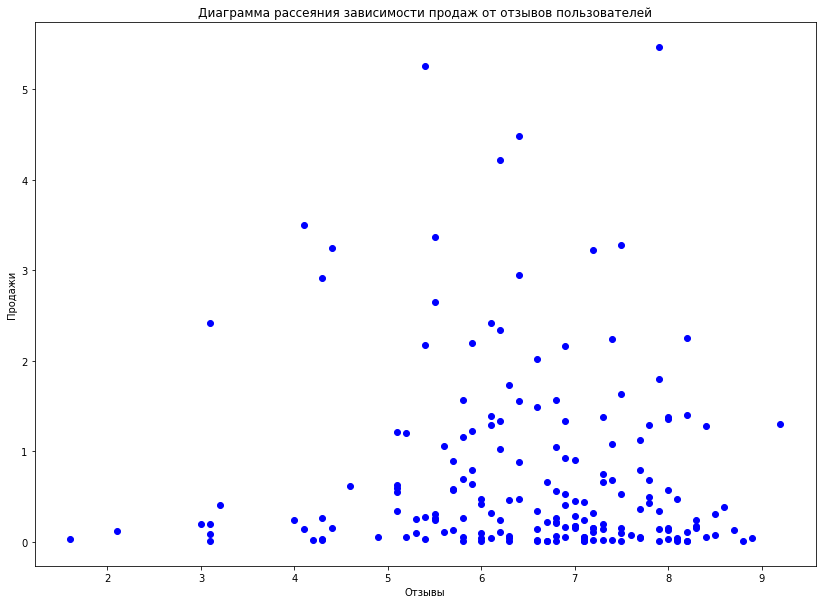

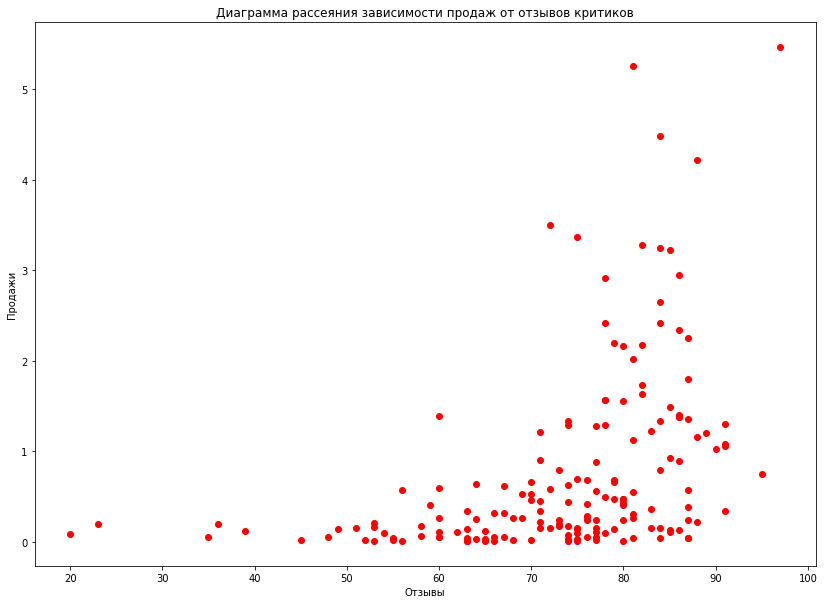

In [45]:
platform_analyzer.scatter_user(xone_data)
platform_analyzer.scatter_critic(xone_data)

In [46]:
platform_analyzer.plat_corr(xone_data)

Кореляция между продажами и оценкой пользователей: -0.06892505328279412
Кореляция между продажами и оценкой критиков: 0.41699832800840175


/tmp/ipykernel_164/117147021.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plat_df['user_score'] = pd.to_numeric(plat_df['user_score'], errors='coerce')
/tmp/ipykernel_164/117147021.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plat_df['critic_score'] = pd.to_numeric(plat_df['critic_score'], errors='coerce')


### Данные для 3DS

In [47]:
platform_analyzer = Platforms_analyse()
ds_data = platform_analyzer.plat_data("3DS")
ds_data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_total
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,NaN,11.68
96,Super Smash Bros. for Wii U and 3DS,3DS,2014,Fighting,3.27,1.37,2.43,0.48,NaN,NaN,NaN,7.55
108,Pokemon Sun/Moon,3DS,2016,Role-Playing,2.98,1.45,2.26,0.45,NaN,NaN,NaN,7.14
184,Tomodachi Life,3DS,2013,Simulation,0.97,2.11,1.90,0.24,NaN,NaN,NaN,5.22
...,...,...,...,...,...,...,...,...,...,...,...,...
16608,Mario & Luigi: Paper Jam & Mario Kart 7 Double...,3DS,2015,Misc,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16610,Kiniro no Corda 3,3DS,2015,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16648,Mushi Bugyou,3DS,2013,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16668,Fujiko F. Fujio Characters: Great Assembly! Sl...,3DS,2014,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01


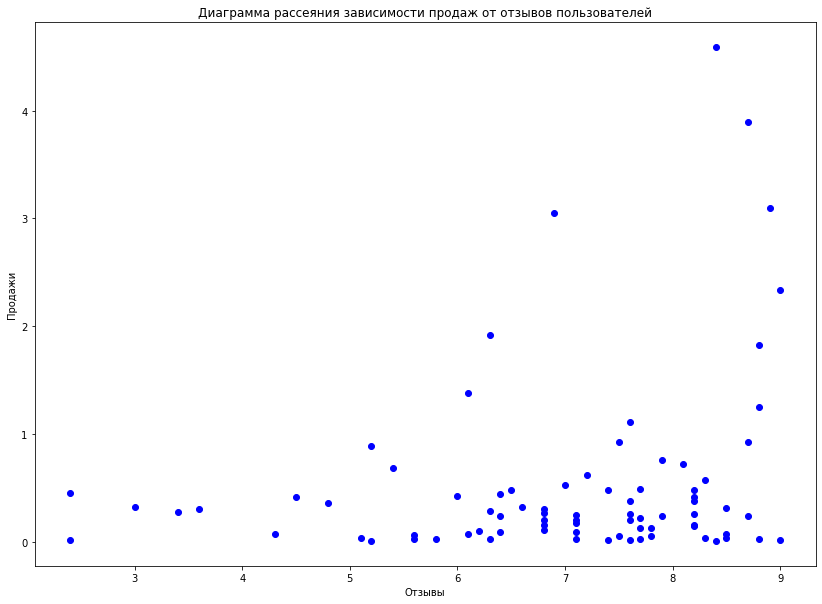

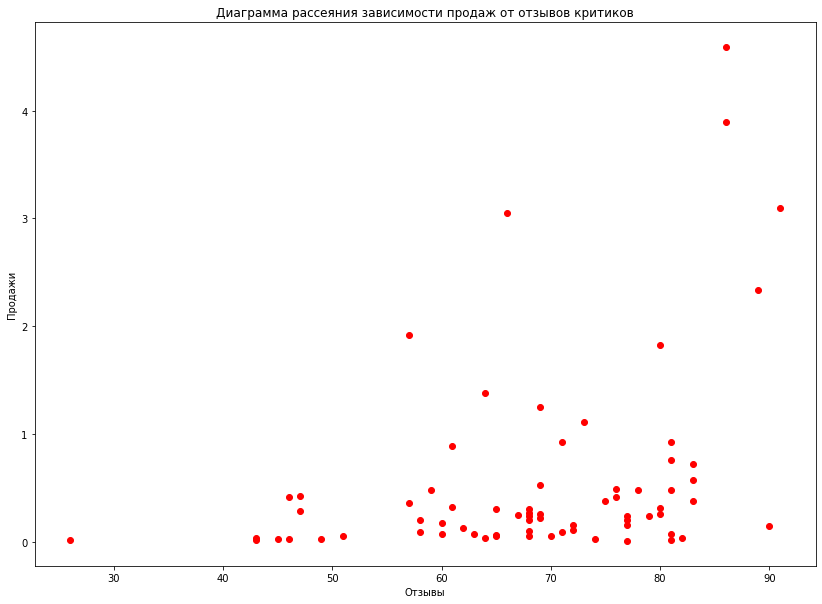

In [48]:
platform_analyzer.scatter_user(ds_data)
platform_analyzer.scatter_critic(ds_data)

In [49]:
platform_analyzer.plat_corr(ds_data)

Кореляция между продажами и оценкой пользователей: 0.24150411773563016
Кореляция между продажами и оценкой критиков: 0.35705661422881035


/tmp/ipykernel_164/117147021.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plat_df['user_score'] = pd.to_numeric(plat_df['user_score'], errors='coerce')
/tmp/ipykernel_164/117147021.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plat_df['critic_score'] = pd.to_numeric(plat_df['critic_score'], errors='coerce')


Проведя анализ для 4 самых популярных платформ было выведен, что продажи больше зависят от оценок критиков нежели от оценки пользователей.


In [50]:
platform_analyzer.plat_corr(data)

NameError: name 'data' is not defined

Однако если взять все данные вместе, то они покажут, что зависимость от оценок критиков все еще больше чем от оценок пользователей, но вот сама зависисмость(продаж от оценок критиков) стала меньше.


In [ ]:
plotbar_filtered(actual_data, 'genre', 'sales_total', 'median', 'Продажи по жанрам', 'Жанры', 'Продажи')

Исходя из полученных графиков самыми популярными являются игры в жанре Platform, а самым не популярными в жанре Adventure.


# Портреты пользователей по регионам

In [ ]:
esrb_rating_mapping = {'E': 4, 'T': 3, 'M': 2, 'A': 1,'tbd':0}
actual_data['numeric_esrb_rating'] = actual_data['rating'].map(esrb_rating_mapping)  # понадобится в будующем для кореляции Пирсона
def region(x):
    return actual_data[['name', 'platform', 'year_of_release', 'genre', x, 'rating', 'numeric_esrb_rating']]

In [ ]:
df_na = region('na_sales')  # Данные по na
df_na

In [ ]:
df_eu = region('eu_sales')  # Данные по eu
df_eu

In [ ]:
df_jp = region('jp_sales')  # Данные по jp
df_jp

In [ ]:
def top(DataFrame, ind, val, func):
    return pd.pivot_table(DataFrame, index=ind, values=val, aggfunc=func) \
        .sort_values(by=val, ascending=False).head(5)

In [ ]:
def pie(df,sales,po,name,title):
    plt.figure(figsize=(10, 10))
    plt.pie(df[sales], labels=df.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Доля продаж по {po} в {name}',y=1.05)
    plt.axis('equal')
    plt.show() 

In [ ]:
platforms_top_na = top(df_na, 'platform', 'na_sales', 'sum')

platforms_top_na['market_share'] = platforms_top_na.na_sales/df_na.na_sales.sum()

pie(platforms_top_na,'na_sales','платформам','Северной Америке','Доля продаж платформ по Северной Америке')

print(platforms_top_na)

In [ ]:
platforms_top_eu = top(df_eu, 'platform', 'eu_sales', 'sum')

platforms_top_eu['market_share'] = platforms_top_eu.eu_sales/df_eu.eu_sales.sum()

pie(platforms_top_eu,'eu_sales','платформам','Европе','Доля продаж платформ по Европе')

print(platforms_top_eu)

In [ ]:
platforms_top_jp = top(df_jp, 'platform', 'jp_sales', 'sum')

platforms_top_jp['market_share'] = platforms_top_jp.jp_sales/df_jp.jp_sales.sum()

pie(platforms_top_jp,'jp_sales','платформам','Японии','Доля продаж платформ по Японии')

print(platforms_top_jp)

In [ ]:
genres_top_na = top(df_na, 'genre', 'na_sales', 'sum')


print(genres_top_na)

pie(genres_top_na,'na_sales','жанрам','Северной Америке','Доля продаж платформ по Северной Америке')

In [ ]:
genres_top_eu = top(df_eu, 'genre', 'eu_sales', 'sum')

print(genres_top_eu)

pie(genres_top_eu,'eu_sales','жанрам','Европе','Доля продаж платформ по Европе')

In [ ]:
genres_top_jp = top(df_jp, 'genre', 'jp_sales', 'sum')

print(genres_top_jp)

pie(genres_top_jp,'jp_sales','жанрам','Японии','Доля продаж платформ по Японии')

In [ ]:
df_eu_filled = df_eu.fillna('Unknown')
eu_rating = top(df_eu_filled, 'rating', 'eu_sales', 'sum')
print(eu_rating)
pie(eu_rating,'eu_sales','ESRB рейтингу','Европе','Доля продаж рейтингов по Европе')

In [ ]:
na_rating_filled = df_na.fillna('Unknown')
na_rating = top(na_rating_filled, 'rating', 'na_sales', 'sum')
print(na_rating)
pie(na_rating,'na_sales','ESRB рейтингу','Северной Америке','Доля продаж рейтингов по Северной Америке')

In [ ]:
jp_rating_filled = df_jp.fillna('Unknown')
jp_rating = top(jp_rating_filled, 'rating', 'jp_sales', 'sum')
print(jp_rating)
pie(jp_rating,'jp_sales','ESRB рейтингу','Японии','Доля продаж рейтингов по Японии')

Очень большую часть рынка занимают игры с неизвестным жанром(значение котором я заполнил пропуски).У Европы и Америки очень похожие рынки у М самый большой спрос, а у Т самый маленький,у Японии с огромным отрывом лидирует Unknown за ним идет Т и самый не популярный рейтинг Е10+


In [ ]:
# Подсчет корреляции между продажами и рейтингом
correlation_na = df_na['na_sales'].corr(df_na['numeric_esrb_rating'])
correlation_eu = df_eu['eu_sales'].corr(df_eu['numeric_esrb_rating'])
correlation_jp = df_jp['jp_sales'].corr(df_jp['numeric_esrb_rating'])
print(f"Коэффициент корреляции между продажами и рейтингом по регионам:"
       f"\nСеверная Америка: {correlation_na}"
       f"\nЕвропа:{correlation_eu}"
       f"\nЯпония:{correlation_jp}")

рейтинг игр слабо влияет на продажи в регионах


# Проверка гипотез

In [ ]:
#Нулевая гипотеза: Средние пользовательские рейтинги Xbox One равны средним пользовательским рейтингам PC.
#Альтернативная гипотеза: Средние пользовательские рейтинги Xbox One не равны средним пользовательским рейтингам PC.
actual_per = df.query("year_of_release >= 2013 & user_score!='tbd'")

actual_per['user_score'] = pd.to_numeric(actual_per['user_score'], errors='coerce')
actual_per = actual_per.dropna(subset=['user_score'])

xbox_one_scores = actual_per[actual_per['platform'] == 'XOne']['user_score']
pc_scores = actual_per[actual_per['platform'] == 'PC']['user_score']

t_statistic, p_value = st.ttest_ind(xbox_one_scores, pc_scores, nan_policy='omit')

print(f"T-статистика: {t_statistic}")
print(f"P-значение: {p_value}")

alpha = 0.05

if p_value < alpha:
    print("Отвергаем нулевую гипотезу: Средние пользовательские рейтинги различаются.")
else:
    print("С большой долей вероятности средние пользовательские рейтинги платформ XOne и PC не имеют статистически значимых отличий")


In [ ]:
#Нулевая гипотеза: Средние пользовательские рейтинги Action не равны средним пользовательским рейтингам Sports.
#Альтернативная гипотеза: Средние пользовательские рейтинги Action равны средним пользовательским рейтингам Sports.
action = actual_per[actual_per['genre'] == 'Action']['user_score']
sports = actual_per[actual_per['genre'] == 'Sports']['user_score']

t_statistic, p_value = st.ttest_ind(action, sports)
alpha = 0.05

if p_value < alpha:
    print('Средние пользовательские рейтинги отличаются')
else:
    print('Средние пользовательские рейтинги равны')


Выбрал такие гипотезы исходя из задания, а alpha задал 0.05 тк это стан


# Вывод

В ходе иследования данных интернет магазина Стримчик, мною были выявлины ключевые закономерности и тренды в индустрии. Работа с данными включала в себя несколько этапов, начиная от предобработки и заканчивая статистическим анализом.

Вот основыне результаты:

    1.Я выявил, что на момент времени предоставленных в данных рынок видеоигр идет на спад.
    
    2.Лидирующими по продажам платформами являются: PS2,X360,Wii,PS3,DS
    
    3.Так же я определил данные на актуальный период, которые помогут обучить модель предсказывать поведение платформы на рынке.
    
    4.На основе актуальных данных выполнил свою реализацию предсказания поведения платформы, которая так же может лечь в основу обучения модели.
    
    5.Выявил, что продажи по платформам не зависят от рейтингов игр выпускаемых на этих платформах.
    
    6.Выявил, что самымии популярными являются игры в жанре action и sports/
    
    7.Постороил портреты пользователей по регионам.
    
    8.Проверил 2 гипотезы(Средние пользовательские рейтинги Xbox One равны средним пользовательским рейтингам PC;Средние  пользовательские рейтинги Xbox One не равны средним пользовательским рейтингам PC.) обе оказались не верны.